In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import normalize

Dataset 1

In [2]:
training_1 = np.loadtxt('./data5/training_1.txt', dtype=np.double)  # 载入数据
test_1 = np.loadtxt('./data5/test_1.txt', dtype=np.double)

In [3]:
train_x_1 = training_1[:, :-1]
train_y_1 = training_1[:, -1]
test_x_1 = test_1[:, :-1]
test_y_1 = test_1[:, -1]

In [4]:
pos_train_1 = training_1[training_1[:, 2] == 1]
neg_train_1 = training_1[training_1[:, 2] == -1]

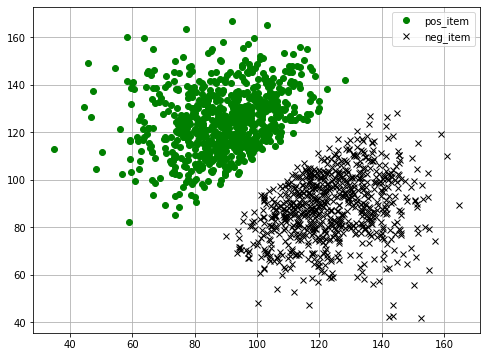

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(pos_train_1[:, 0], pos_train_1[:, 1], 'og', label='pos_item')
plt.plot(neg_train_1[:, 0], neg_train_1[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

Regularized SVM:
$$
\begin{align*}
\mathop{min}\limits_{w,b,\xi}\quad & \frac{1}{2}||w||^2 + C\sum_{i=1}^m\xi_i \\
s.t.\quad & y^{(i)}(w^Tx^{(i)}+b)\ge 1-\xi_i,\forall i=1, ...,m \\
& \xi_i \ge 0, \forall i=1, ..., m
\end{align*}
$$
对偶问题：
$$
\begin{align*}
\mathop{max}\limits_{\alpha}\quad & \sum_{i=1}^m\alpha_i-\frac{1}{2}\sum_{i,j=1}^my^{(i)}y^{(j)}\alpha_i\alpha_j <x^{(i)},x^{(j)}> \\
s.t.\quad & 0\le\alpha_i\le C,\forall i=1, ...,m \\
& \sum_{i=1}^m\alpha_iy^{(i)}=0
\end{align*}
$$
问题转变为：
$$
\mathop{min}\limits_{\alpha}\quad \frac{1}{2}\sum_{i,j=1}^my^{(i)}y^{(j)}\alpha_i\alpha_j <x^{(i)},x^{(j)}>-\sum_{i=1}^m\alpha_i
$$
由此求解：
$$
\begin{align*}
&w^*=\sum^N_{i=1}\alpha_i^*y_ix_i \\
&b^*=y_j-\sum^N_{i=1}y_i\alpha_i^*<x_i, x_j>
\end{align*}
$$
分离超平面：
$$
w^*·x+b^*=0
$$

In [6]:
def get_H(x, y):
    m, n = x.shape
    P = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            P[i, j] = np.dot(x[i], x[j]) * y[i] * y[j]
    return P

In [7]:
def get_w(alpha, x, y):
    w = np.zeros(x.shape)
    w[:, 0] = x[:, 0] * alpha * y
    w[:, 1] = x[:, 1] * alpha * y
    return np.sum(w, axis=0)

In [8]:
def get_b(alpha, w, x, y, C):
    m, n = x.shape
    index = []
    for i in range(m):
        if alpha[i] > 0 and alpha[i] < C:
            index.append(i)
    index = np.array(index)
    
    x = x[index]
    y = y[index]

    return (y - np.dot(x, w)).sum() / len(index)

In [9]:
def solve_dual_1(x, y, C):
    m, n = x.shape
    P = get_H(x, y)
    q = np.ones(m) * (-1)
    G, h = None, None
    A = y.astype('float')
    b = np.zeros(1)
    lb = np.zeros(m)
    ub = np.ones(m) * C
    
    alpha = solve_qp(P, q, G, h, A, b, lb, ub, solver='cvxopt')
    # print(alpha)

    w = get_w(alpha, x, y)
    b = get_b(alpha, w, x, y, C)

    return w, b

In [10]:
def pred(w, b, x):
    return np.dot(x, w) + b

In [11]:
def display_contour(w, b):
    x_1 = np.linspace(40, 180, 400)
    x_2 = np.linspace(40, 180, 400)
    p = np.zeros((len(x_1), len(x_2)))

    for i in range(len(x_1)):
        for j in range(len(x_2)):
            p[i][j] = pred(w, b, np.array((x_1[i], x_2[j])))

    contour_zero = plt.contour(x_1, x_2, p, [0.])
    contour_pos = plt.contour(x_1, x_2, p, [1.])
    contour_neg = plt.contour(x_1, x_2, p, [-1.])
    plt.clabel(contour_zero, inline=1, fontsize=15)
    plt.clabel(contour_pos, inline=1, fontsize=15)
    plt.clabel(contour_neg, inline=1, fontsize=15)

In [12]:
w_1_1, b_1_1 = solve_dual_1(train_x_1, train_y_1, 1)
w_1_2, b_1_2 = solve_dual_1(train_x_1, train_y_1, 0.1)
w_1_3, b_1_3 = solve_dual_1(train_x_1, train_y_1, 0.01)

In [13]:
w_1_1, b_1_1

(array([-0.12465646,  0.1269073 ]), -0.21399825880628998)

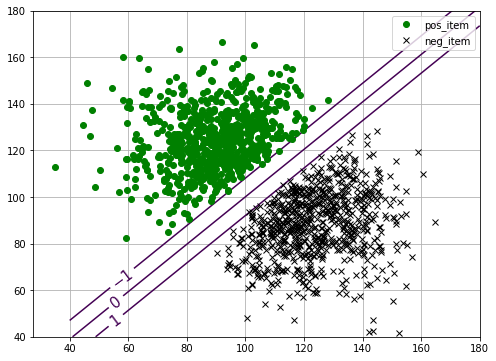

In [14]:
plt.figure(figsize=(8, 6))
display_contour(w_1_1, b_1_1)
plt.plot(pos_train_1[:, 0], pos_train_1[:, 1], 'og', label='pos_item')
plt.plot(neg_train_1[:, 0], neg_train_1[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

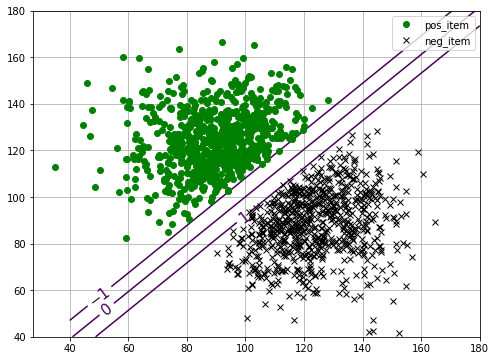

In [15]:
plt.figure(figsize=(8, 6))
display_contour(w_1_2, b_1_2)
plt.plot(pos_train_1[:, 0], pos_train_1[:, 1], 'og', label='pos_item')
plt.plot(neg_train_1[:, 0], neg_train_1[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

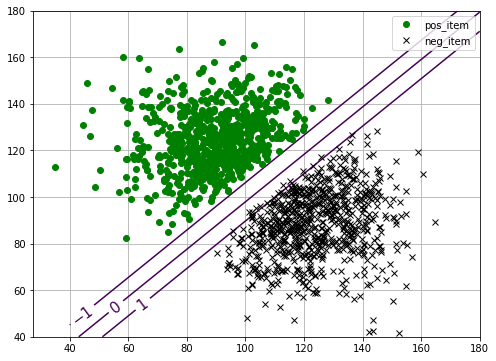

In [16]:
plt.figure(figsize=(8, 6))
display_contour(w_1_3, b_1_3)
plt.plot(pos_train_1[:, 0], pos_train_1[:, 1], 'og', label='pos_item')
plt.plot(neg_train_1[:, 0], neg_train_1[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

In [17]:
def get_accuracy(x, y, w, b, show_false_pos=False):
    m, n = x.shape

    p = pred(w, b, x)
    false_pos = []

    num = 0
    for i in range(m):
        if p[i] > 0 and y[i] == 1:
            num += 1
        elif p[i] < 0 and y[i] == -1:
            num += 1
        else:
            false_pos.append(i)

    if show_false_pos:
        print('false_pos:', false_pos[:10])

    return num / m

In [18]:
get_accuracy(test_x_1, test_y_1, w_1_1, b_1_1)

1.0

Dataset 2

In [19]:
training_2 = np.loadtxt('./data5/training_2.txt', dtype=np.int32)  # 载入数据
test_2 = np.loadtxt('./data5/test_2.txt', dtype=np.int32)

In [20]:
train_x_2 = training_2[:, :-1]
train_y_2 = training_2[:, -1]
test_x_2 = test_2[:, :-1]
test_y_2 = test_2[:, -1]

In [21]:
pos_train_2 = training_2[training_2[:, 2] == 1]
neg_train_2 = training_2[training_2[:, 2] == -1]

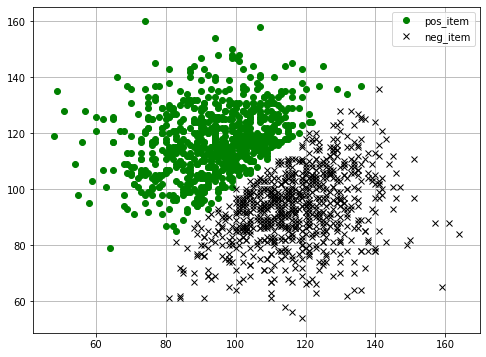

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(pos_train_2[:, 0], pos_train_2[:, 1], 'og', label='pos_item')
plt.plot(neg_train_2[:, 0], neg_train_2[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

In [23]:
w_2_1, b_2_1 = solve_dual_1(train_x_2, train_y_2, 1)
w_2_2, b_2_2 = solve_dual_1(train_x_2, train_y_2, 0.1)
w_2_3, b_2_3 = solve_dual_1(train_x_2, train_y_2, 0.01)

In [24]:
w_2_1, b_2_1

(array([-0.96692603,  0.97081709]), 0.7905960973416046)

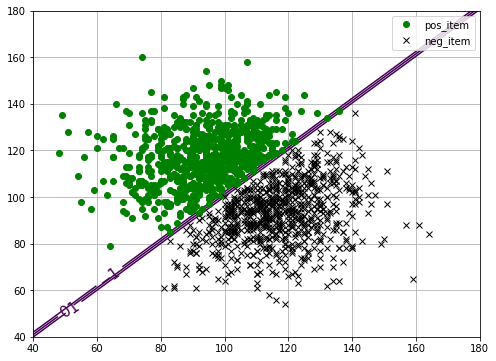

In [25]:
plt.figure(figsize=(8, 6))
display_contour(w_2_1, b_2_1)
plt.plot(pos_train_2[:, 0], pos_train_2[:, 1], 'og', label='pos_item')
plt.plot(neg_train_2[:, 0], neg_train_2[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

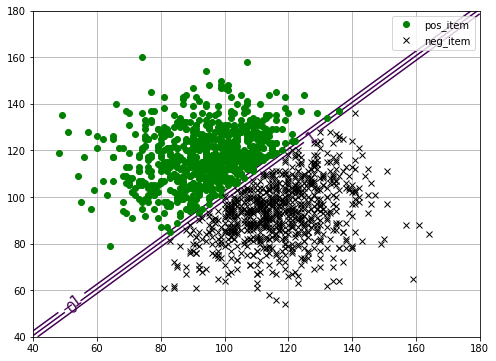

In [26]:
plt.figure(figsize=(8, 6))
display_contour(w_2_2, b_2_2)
plt.plot(pos_train_2[:, 0], pos_train_2[:, 1], 'og', label='pos_item')
plt.plot(neg_train_2[:, 0], neg_train_2[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

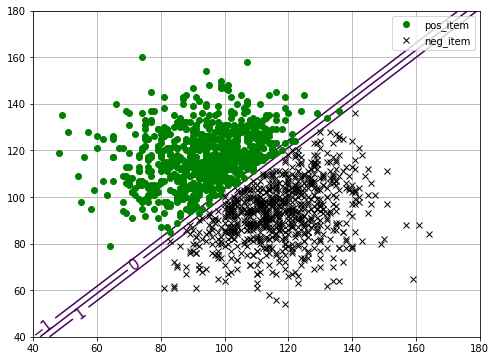

In [27]:
plt.figure(figsize=(8, 6))
display_contour(w_2_3, b_2_3)
plt.plot(pos_train_2[:, 0], pos_train_2[:, 1], 'og', label='pos_item')
plt.plot(neg_train_2[:, 0], neg_train_2[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

In [28]:
get_accuracy(test_x_2, test_y_2, w_2_2, b_2_2)

1.0

Handwritten Digit Recognition

In [29]:
def strimage(n):
    digit_dict = {}
    i = 0
    with open('./data5/train-01-images.svm', 'r') as f:
        for it in f.readlines():
            digit_dict[i] = it[3:]
            i += 1

    x = np.array([int(j[0]) for j in [i.split(':') for i in digit_dict[n].split()]])
    y = np.array([int(j[1]) for j in [i.split(':') for i in digit_dict[n].split()]])

    grid = np.zeros(784)
    grid[x] = y
    grid1 = grid.reshape(28, 28)
    grid1 = grid1 * 100 / 255

    # grid1 = grid1.reshape(28, 28)
    # grid1 = np.fliplr(np.diag(np.ones((28)))) * grid1
    # grid1 = np.rot90(grid1, 3)

    plt.imshow(grid1)

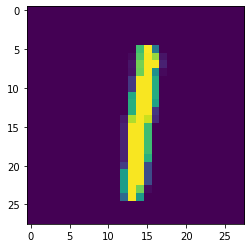

In [30]:
strimage(10)

In [31]:
def extractLBPFeature(digit_data):
    data = np.zeros((digit_data.shape[0], 59))

    for i in range(digit_data.shape[0]):
        temp = local_binary_pattern(digit_data[i].reshape(28, 28), 8, 1, 'nri_uniform')
        data[i] = np.array(np.bincount(temp.astype(np.int64).flatten().tolist(), minlength=59))

    data = normalize(data)
    return data

In [32]:
def get_digit_data():
    digit_train_dict, digit_test_dict = {}, {}
    num1, num2 = 0, 0
    digit_train_label, digit_test_label = [], []
    with open('./data5/train-01-images.svm', 'r') as f:
        for it in f.readlines():
            digit_train_dict[num1] = it[3:]
            digit_train_label.append(int(it[:2]))
            num1 += 1
    with open('./data5/test-01-images.svm', 'r') as f:
        for it in f.readlines():
            digit_test_dict[num2] = it[3:]
            digit_test_label.append(int(it[:2]))
            num2 += 1

    train_index = np.random.randint(0, len(digit_train_dict), 2000)

    train_data = np.zeros((len(digit_train_dict), 784))
    test_data = np.zeros((len(digit_test_dict), 784))
    digit_train_label = np.array(digit_train_label)
    digit_test_label = np.array(digit_test_label)

    for key, value in digit_train_dict.items():
        x = np.array([int(j[0]) for j in [i.split(':') for i in value.split()]])
        y = np.array([int(j[1]) for j in [i.split(':') for i in value.split()]])
        train_data[key][x] = y

    for key, value in digit_test_dict.items():
        x = np.array([int(j[0]) for j in [i.split(':') for i in value.split()]])
        y = np.array([int(j[1]) for j in [i.split(':') for i in value.split()]])
        test_data[key][x] = y
    
    return extractLBPFeature(train_data[train_index]), digit_train_label[train_index], train_index, extractLBPFeature(test_data), digit_test_label
    # return train_data, digit_train_label, test_data, digit_test_label

In [33]:
digit_train_data, digit_train_label, train_index, digit_test_data, digit_test_label = get_digit_data()

In [34]:
digit_train_data.shape

(2000, 59)

In [35]:
digit_train_data[0]

array([0.00145167, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00145167, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00145167, 0.00145167, 0.01016167,
       0.        , 0.        , 0.        , 0.01016167, 0.        ,
       0.        , 0.        , 0.01742001, 0.        , 0.        ,
       0.00145167, 0.01742001, 0.        , 0.        , 0.        ,
       0.02758169, 0.00145167, 0.00145167, 0.        , 0.02903336,
       0.00290334, 0.        , 0.        , 0.        , 0.00145167,
       0.        , 0.        , 0.        , 0.        , 0.00580667,
       0.        , 0.        , 0.        , 0.004355  , 0.        ,
       0.        , 0.        , 0.99874746, 0.00290334])

In [36]:
def get_b_2(alpha, w, x, y):
    m, n = x.shape
    index = []
    for i in range(m):
        if alpha[i] > 0:
            index.append(i)
    index = np.array(index)
    
    x = x[index]
    y = y[index]

    return (y - np.dot(x, w)).sum() / len(index)

In [37]:
def solve_dual_2(x, y):
    m, n = x.shape
    P = get_H(x, y)
    q = np.ones(m) * (-1)
    G, h = None, None
    A = y.astype('float')
    b = np.zeros(1)
    lb = np.zeros(m)
    ub = None
    
    alpha = solve_qp(P, q, G, h, A, b, lb, ub, solver='cvxopt')
    # print(alpha)

    w = get_w(alpha, x, y)
    b = get_b_2(alpha, w, x, y)

    return w, b

In [38]:
w_3, b_3 = solve_dual_2(digit_train_data, digit_train_label)
p1 = get_accuracy(digit_train_data, digit_train_label, w_3, b_3, show_false_pos=True)
p2 = get_accuracy(digit_test_data, digit_test_label, w_3, b_3, show_false_pos=True)

p1, p2

false_pos: [5, 7, 12, 16, 17, 19, 20, 21, 22, 23]
false_pos: [6, 7, 17, 20, 37, 51, 52, 57, 63, 68]


(0.7695, 0.7735224586288416)

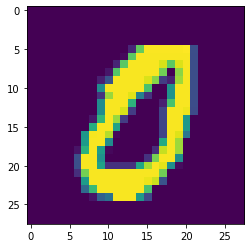

In [39]:
strimage(23)

In [40]:
C = [0.001, 0.01, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 1e6]
for c in C:
    temp_w, temp_b = solve_dual_1(digit_train_data, digit_train_label, c)
    p1 = get_accuracy(digit_train_data, digit_train_label, temp_w, temp_b)
    p2 = get_accuracy(digit_test_data, digit_test_label, temp_w, temp_b)
    print('C = {}:'.format(c), p1, p2)

C = 0.001: 0.5465 0.5366430260047281
C = 0.01: 0.5465 0.5366430260047281
C = 0.1: 0.5465 0.5366430260047281
C = 1: 0.591 0.5787234042553191
C = 10: 0.6825 0.6728132387706856
C = 100.0: 0.7025 0.6912529550827423
C = 1000.0: 0.7215 0.7177304964539007
C = 10000.0: 0.74 0.7404255319148936
C = 100000.0: 0.768 0.7650118203309693
C = 1000000.0: 0.7695 0.7735224586288416


### Non-Linear SVM

In [41]:
training_3 = np.loadtxt('./data5/training_3.text', dtype=np.double)  # 载入数据

In [42]:
train_x_3 = training_3[:, :-1]
train_y_3 = training_3[:, -1]

In [43]:
pos_train_3 = training_3[training_3[:, -1] == 1]
neg_train_3 = training_3[training_3[:, -1] == -1]

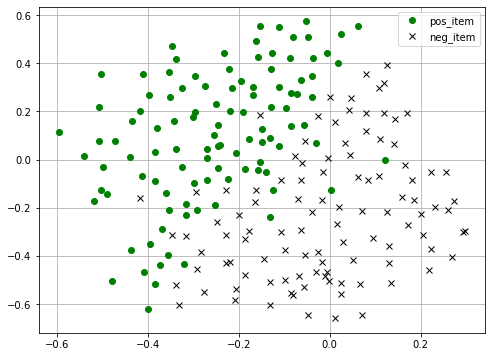

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(pos_train_3[:, 0], pos_train_3[:, 1], 'og', label='pos_item')
plt.plot(neg_train_3[:, 0], neg_train_3[:, 1], 'xk', label='neg_item')
plt.grid()
plt.legend()
plt.show()

Radial Basis Function kernel:
$$
K(x^{(i)}, x^{(j)})=\phi(x^{(i)})^T\phi(x^{(j)})=exp(-\gamma||x^{(i)}-x^{(j)}||^2),\gamma>0
$$

In [45]:
def kernel(x_i, x_j, gamma):
    x_i, x_j = x_i.reshape(-1), x_j.reshape(-1)
    return np.exp(-np.dot((x_i-x_j).T, (x_i-x_j)) * gamma)

求解最优化问题：
$$
\begin{align*}
\mathop{min}\limits_{\alpha}\quad & \frac{1}{2}\sum^{N}_{i=1}\sum^{N}_{j=1}\alpha_i\alpha_jy_iy_jK(x_i, x_j)-\sum^{N}_{i=1}\alpha_i \\
s.t.\quad & \sum^N_{i=1}\alpha_iy_i=0 \\
& 0\le\alpha_i\le C, i=1,2,\dots,N
\end{align*}
$$

In [46]:
def get_H_2(x, y, gamma):
    m, n = x.shape
    P = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            P[i, j] = kernel(x[i], x[j], gamma) * y[i] * y[j]
    return P

$$
b^*=y_j-\sum^{N}_{i=1}a^*_iy_iK(x_i,x_j)
$$

In [47]:
def get_b_2(alpha, gamma, C, x, y):
    m, n = x.shape
    index = []
    for i in range(m):
        if alpha[i] > 0 and alpha[i] < C:
            index.append(i)
    index = np.array(index)
    
    x_j = x[index]
    y_j = y[index]

    temp = np.zeros(y_j.shape)
    for i in range(len(y)):
        for j in range(len(index)):
            temp[i] += alpha[i] * y[i] * kernel(x[i], x_j[j], gamma)

    # return (y - temp).sum()
    return (y_j - temp).sum() / len(index)

In [48]:
def solve_dual_kernel(x, y, gamma, C):
    m, n = x.shape
    P = get_H_2(x, y, gamma)
    q = np.ones(m) * (-1)
    G, h = None, None
    A = y.astype('float')
    b = np.zeros(1)
    lb = np.zeros(m)
    ub = np.ones(m) * C
    
    alpha = solve_qp(P, q, G, h, A, b, lb, ub, solver='cvxopt')
    # print(alpha)

    b = get_b_2(alpha, gamma, C, x, y)

    return alpha, b

In [49]:
C = 0.1
gamma_1, gamma_2, gamma_3, gamma_4 = 1, 10, 100, 1000
alpha_1, b_1 = solve_dual_kernel(train_x_3, train_y_3, gamma_1, C)
alpha_2, b_2 = solve_dual_kernel(train_x_3, train_y_3, gamma_2, C)
alpha_3, b_3 = solve_dual_kernel(train_x_3, train_y_3, gamma_3, C)
alpha_4, b_4 = solve_dual_kernel(train_x_3, train_y_3, gamma_4, C)

决策函数：
$$
f(x)=sign(\sum^N_{i=1}\alpha^*_iy_iK(x, x_i)+b^*)
$$

In [50]:
def pred_2(x_i, x, y, alpha, b, gamma):
    temp = []
    for i in range(x.shape[0]):
        temp.append(kernel(x_i, x[i], gamma))
    
    temp = np.array(temp)

    return (temp * alpha * y).sum() + b

In [51]:
def showplot_3(alpha, b, gamma):
    plt.figure(figsize=(8, 6))
    x_1 = np.linspace(-0.7, 0.4, 100)
    x_2 = np.linspace(-0.7, 0.7, 100)
    p = np.zeros((len(x_1), len(x_2)))

    for i in range(len(x_1)):
        for j in range(len(x_2)):
            p[j][i] = pred_2(np.array((x_1[i], x_2[j])), train_x_3, train_y_3, alpha, b, gamma)

    plt.contour(x_1, x_2, p, [0.])

    plt.plot(pos_train_3[:, 0], pos_train_3[:, 1], 'og', label='pos_item')
    plt.plot(neg_train_3[:, 0], neg_train_3[:, 1], 'xk', label='neg_item')
    plt.grid()
    plt.legend()
    plt.show()

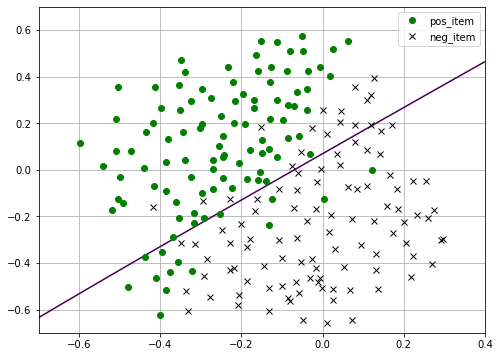

In [52]:
showplot_3(alpha_1, b_1, gamma_1)

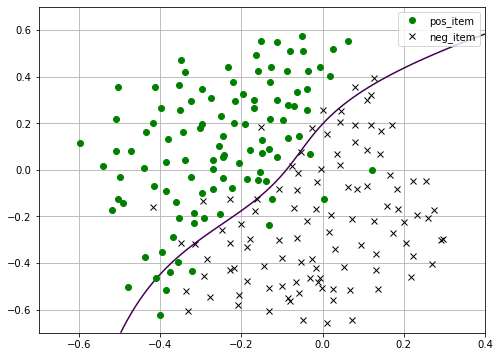

In [53]:
showplot_3(alpha_2, b_2, gamma_2)

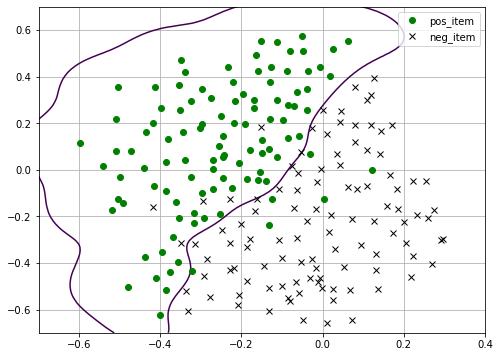

In [54]:
showplot_3(alpha_3, b_3, gamma_3)

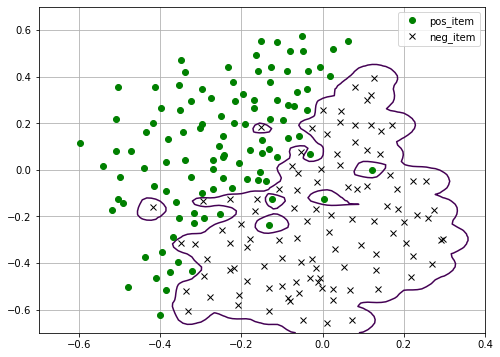

In [55]:
showplot_3(alpha_4, b_4, gamma_4)

### Sequential Minimal Optimization

$$
g(x)=\sum^N_{i=1}\alpha_iy_iK(x_i, x)+b
$$

In [56]:
def g(x_i, x, y, alpha, b, gamma):
    temp = []
    for i in range(x.shape[0]):
        temp.append(kernel(x_i, x[i], gamma))
    
    temp = np.array(temp)

    return (temp * alpha * y).sum() + b

$$
E_i=g(x_i)-y_i=(\sum^N_{j=1}\alpha_jy_jK(x_j,x_i)+b)-y_i,\quad i=1,2
$$

In [57]:
def cal_E(x_i, y_i, x, y, alpha, b, gamma):
    return g(x_i, x, y, alpha, b, gamma) - y_i

In [58]:
def KKT(i, alpha, x, y, b, gamma, C):
    temp = y[i]*g(x[i], x, y, alpha, b, gamma)
    if (alpha[i] == 0) and (temp >= 1):
        return True, 0
    elif (alpha[i] > 0 and alpha[i] < C) and (temp == 1):
        return True, 0
    elif (alpha[i] == C) and (temp <= 1):
        return True, 0
    else:
        return False, abs(temp-1)

停机条件：
$$
\sum^N_{i=1}\alpha_iy_i=0, \quad 0\le\alpha_i\le C, \quad i=1, 2, \dots, N 
$$

$$
y_i · g(x_i)
\begin{cases}
& \ge 1, \quad \{x_i|\alpha_i=0\} \\
& = 1, \quad \{x_i|0<\alpha_i<C\} \\
& \le 1, \quad \{x_i|\alpha_i=C\}
\end{cases}
$$

In [59]:
def judge(alpha, x, y, C, b, gamma):
    m = alpha.shape[0]
    if (alpha >= 0).sum() != m:
        return False
    if (alpha <= C).sum() != m:
        return False
    if (alpha*y).sum() != 0:
        return False
    for i in range(m):
        flag, temp = KKT(i, alpha, x, y, b, gamma, C)
        if not flag:
            return False

    return True

$$
\begin{align*}
&b_1^{new}=-E_1-y_1K_{11}(\alpha_1^{new}-\alpha_1^{old})-y_2K_{21}(\alpha_2^{new}-\alpha_2^{old})+b^{old} \\
&b_2^{new}=-E_2-y_1K_{12}(\alpha_1^{new}-\alpha_1^{old})-y_2K_{22}(\alpha_2^{new}-\alpha_2^{old})+b^{old} \\
&b^{new}=\frac{b_1+b_2}{2}
\end{align*}
$$

In [60]:
def cal_b(gamma, E_1, E_2, x_1, x_2, y_1, y_2, alpha_1_new, alpha_1_old, alpha_2_new, alpha_2_old, b_old):
    b_1_new = -E_1-y_1*kernel(x_1, x_1, gamma)*(alpha_1_new-alpha_1_old)-y_2*kernel(x_2, x_1, gamma)*(alpha_2_new-alpha_2_old)+b_old
    b_2_new = -E_2-y_1*kernel(x_1, x_2, gamma)*(alpha_1_new-alpha_1_old)-y_2*kernel(x_2, x_2, gamma)*(alpha_2_new-alpha_2_old)+b_old

    return (b_1_new+b_2_new) / 2

$$
E_i^{new}=\sum_{S}y_j\alpha_jK(x_i,x_j)+b^{new}-y_i
$$

In [61]:
def get_E(alpha, x, y, b, C, gamma):
    m = alpha.shape[0]
    E_new = []
    for i in range(m):
        E_new.append(cal_E(x[i], y[i], x, y, alpha, b, gamma))
    
    return E_new

In [62]:
def SMO(x, y, gamma, C, iter=400):
    m, n = x.shape
    alpha_hat = np.zeros(m)
    b = 1
    index_1, index_2 = 1, 0

    while (iter > 0):
        E = get_E(alpha_hat, x, y, b, C, gamma)

        max_ = -1
        for i in range(m):
            flag, temp = KKT(i, alpha_hat, x, y, b, gamma, C)
            if not flag and max_ < temp:
                index_1 = i
                max_ = temp

        if E[index_1] > 0:
            index_2 = E.index(min(E))
        else:
            index_2 = E.index(max(E))

        alpha_1, alpha_2 = alpha_hat[index_1], alpha_hat[index_2]
        x_1, x_2 = x[index_1], x[index_2]
        y_1, y_2 = y[index_1], y[index_2]
        E_1, E_2 = E[index_1], E[index_2]
        
        if y_1 == y_2:
            L, H = max(0, alpha_2+alpha_1-C), min(C, alpha_2+alpha_1)
        else:
            L, H = max(0, alpha_2-alpha_1), min(C, C+alpha_2-alpha_1)
        
        alpha_2_new_unc = alpha_2 + (y_2*(E_1-E_2)/(kernel(x_1, x_1, gamma)+kernel(x_2, x_2, gamma)-2*kernel(x_1, x_2, gamma)))

        if alpha_2_new_unc > H:
            alpha_2_new = H
        elif alpha_2_new_unc < L:
            alpha_2_new = L
        else:
            alpha_2_new = alpha_2_new_unc

        alpha_2_new = alpha_2_new_unc

        alpha_1_new = alpha_1 + y_1*y_2*(alpha_2-alpha_2_new)

        alpha_hat[index_1], alpha_hat[index_2] = alpha_1_new, alpha_2_new

        b = cal_b(gamma, E_1, E_2, x_1, x_2, y_1, y_2, alpha_1_new, alpha_1, alpha_2_new, alpha_2, b)

        if judge(alpha_hat, x, y, C, b, gamma):
            break

        iter -= 1

    return alpha_hat, b

In [63]:
def get_accuracy_2(train_x, train_y, alpha, b, gamma):
    m = train_x.shape[0]
    cnt = 0
    for i in range(m):
        temp = pred_2(train_x[i], train_x, train_y, alpha, b, gamma)
        if temp >= 0 and train_y[i] == 1:
            cnt += 1
        elif temp < 0 and train_y[i] == -1:
            cnt += 1

    return cnt / m

In [64]:
gamma, C = 100, 0.1

0.8767772511848341


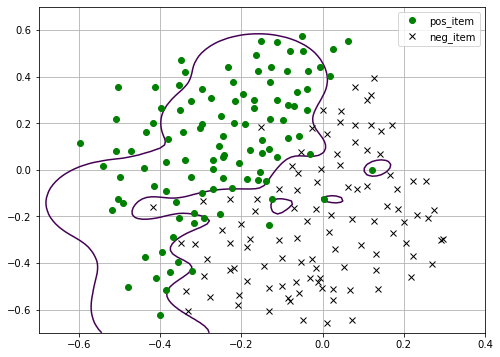

In [65]:
alpha_4_1, b_4_1 = SMO(train_x_3, train_y_3, gamma, C, iter=100)
print(get_accuracy_2(train_x_3, train_y_3, alpha_4_1, b_4_1, gamma))
showplot_3(alpha_4_1, b_4_1, gamma)

0.966824644549763


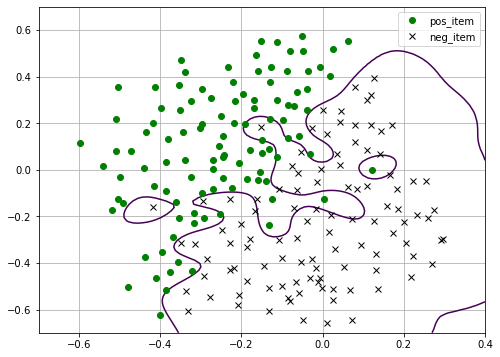

In [66]:
alpha_4_2, b_4_2 = SMO(train_x_3, train_y_3, gamma, C, iter=200)
print(get_accuracy_2(train_x_3, train_y_3, alpha_4_2, b_4_2, gamma))
showplot_3(alpha_4_2, b_4_2, gamma)

1.0


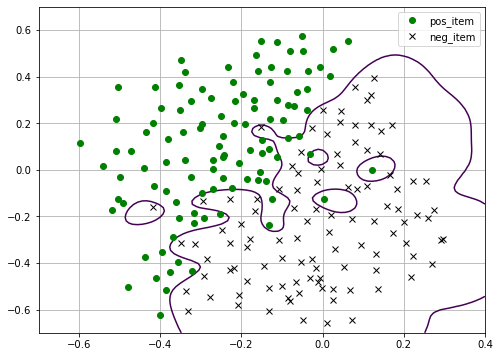

In [67]:
alpha_4_3, b_4_3 = SMO(train_x_3, train_y_3, gamma, C, iter=300)
print(get_accuracy_2(train_x_3, train_y_3, alpha_4_3, b_4_3, gamma))
showplot_3(alpha_4_3, b_4_3, gamma)

1.0


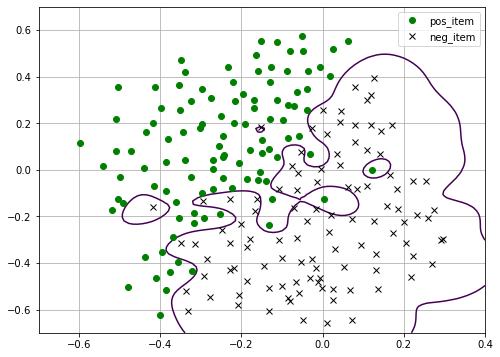

In [68]:
alpha_4_4, b_4_4 = SMO(train_x_3, train_y_3, gamma, C, iter=400)
print(get_accuracy_2(train_x_3, train_y_3, alpha_4_4, b_4_4, gamma))
showplot_3(alpha_4_4, b_4_4, gamma)